In [1]:
import sys
sys.path.append('../../pybeh')
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import cmlreaders as cml
from SimulatedSubjectData import *
from pandas_to_pybeh import pd_crp, get_all_matrices, pd_temp_fact
import matplotlib.pyplot as plt
import pickle
pd.set_option("display.max_columns", None)
import os
import cmldask.CMLDask as da
import cmldask
from dask.distributed import wait, as_completed, progress
from dask import delayed, compute
import logging
import glob
import seaborn as sns

In [2]:
list_len = 15
num_lists = 1000

exp = 'CourierReinstate1'
subjects = ['LTP564', 'LTP565', 'LTP566', 'LTP567', 'LTP568', 'LTP569', 'LTP571', 'LTP572', 'LTP573',
            'LTP574', 'LTP575', 'LTP576', 'LTP577', 'LTP578', 'LTP579', 'LTP580', 'LTP581', 'LTP583',
            'LTP584', 'LTP585', 'LTP586', 'LTP587', 'LTP588', 'LTP589', 'LTP590', 'LTP591', 'LTP592', 
            'LTP593', 'LTP594', 'LTP595', 'LTP596', 'LTP597', 'LTP598', 'LTP599', 'LTP600', 'LTP601', 
            'LTP602', 'LTP603', 'LTP604', 'LTP605']

In [3]:
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Dictionary saved to {filename}")

def load_data(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [4]:
df = cml.get_data_index('ltp', rootdir='/').query("experiment == @exp")

full_evs = None
for i, row in df.iterrows():
    reader = cml.CMLReader(subject=row['subject'], experiment=row['experiment'], session=row['session'])
    evs = reader.load('task_events')
    full_evs = evs if full_evs is None else pd.concat([full_evs, evs], ignore_index=True)
full_evs = full_evs.query("subject in @subjects")
full_evs = full_evs[(full_evs['item'] != "AMPLIFIER") & (full_evs['item'] != "APPLE") & (full_evs['item'] != "AXE") & 
                    (full_evs['item'] != "BASKETBALL_HOOP") & (full_evs['item'] != "DOOR") & (full_evs['item'] != "IRONING_BOARD") & 
                    (full_evs['item'] != "SHOVEL") & (full_evs['item'] != "STOVE")]

In [5]:
with open("words.pkl", "rb") as f:
    wordpool = pickle.load(f)

In [6]:
def compute_recall_rate(data):
    word_evs = data[data['type'] == 'WORD']
    return word_evs['recalled'].sum() / len(word_evs)

def compute_first_recall(data, list_len):
    rec_evs = data[data['type'] == 'REC_WORD']
    rec_evs['pos'] = rec_evs.groupby(['session', 'trial']).cumcount()
    first_recall_df = rec_evs.query('pos == 0 and serialpos >= 0')
    first_recall_df = first_recall_df.groupby(
        ['serialpos']).agg(
        {'recalled': 'count'}).reindex(range(1, list_len+1), fill_value=0)
    n_lists = first_recall_df['recalled'].sum()
    return first_recall_df['recalled'].to_numpy(dtype=float) / n_lists

def compute_lag_crp_single_subject_array(
    data, 
    list_len
):
    center = list_len - 1
    min_lag = -center
    max_lag = center + 1
    actual = {lag: 0 for lag in range(min_lag, max_lag)}
    possible = {lag: 0 for lag in range(min_lag, max_lag)}
    for session_id, session_data in data.groupby('session'):
        recalls = session_data[session_data.type == 'REC_WORD']
        # print(recalls)
        words = session_data[session_data.type == 'WORD']
        if recalls.empty or words.empty:
            print(f"session {session_id} has no events")
            continue
        # print(recalls.intruded)
        recalls = recalls[(recalls['trial'] != -999)]
        word_to_pos = dict(zip(words['item'], words['serialpos']))
        # print(word_to_pos)
        # print(recalls)
        for trial in recalls['trial'].unique():
            trial_words = words[words['trial'] == trial]['item'].tolist()
            trial_recalls = (recalls[recalls['trial'] == trial]
                             .sort_values('rectime')
                             .drop_duplicates('item'))
            
            if len(trial_recalls) < 2:
                print(f"session {session_id}, trial {trial} doesn't have enough events")
                continue
            trial_recalls = trial_recalls[trial_recalls['item'].isin(trial_words)]
            recall_pos = [word_to_pos[w] for w in trial_recalls['item']]
            # print(recall_pos)
            for i, cur in enumerate(recall_pos[:-1]):
                lag = recall_pos[i+1] - cur
                if min_lag <= lag <= max_lag and lag != 0:
                    actual[lag] += 1
                for pos in set(range(1, list_len+1)) - set(recall_pos[:i+1]):
                    pl = pos - cur
                    if min_lag <= pl <= max_lag and pl != 0:
                        possible[pl] += 1

    # build CRP array
    full_len = 2*list_len - 1
    crp = np.full(full_len, np.nan)
    center = list_len - 1
    for lag in range(min_lag, max_lag):
        idx = center + lag
        if 0 <= idx < full_len:
            crp[idx] = (actual[lag] / possible[lag]) if possible[lag] > 0 else np.nan
    crp[center] = 0.0
    return crp

In [7]:
# CourierReinstate1 data
sub_parameters = {}

for sub in subjects:
    df_sub = full_evs[full_evs['subject'] == sub]
    recall_rate = compute_recall_rate(df_sub)
    first_recall = compute_first_recall(df_sub, list_len)
    lag_crp = compute_lag_crp_single_subject_array(df_sub, list_len)
    sub_parameters[sub] = {
        'recall_rate': recall_rate,
        'first_recall': first_recall,
        'lag_crp': lag_crp
    }

session 2, trial 7 doesn't have enough events


In [8]:
def load_all_subjects_optimized(folder):
    """
    Loads all {subject}_optimized.pkl files in the folder and combines them into a single dictionary.
    """
    all_data = {}
    # find all files ending with _optimized.pkl
    files = glob.glob(os.path.join(folder, "*_optimized.pkl"))
    
    for file in files:
        with open(file, 'rb') as f:
            subject_data = pickle.load(f)  # this is a single dict like {'LTP564': {...}}
            # merge into all_data
            all_data.update(subject_data)
    
    return all_data

In [9]:
subj_optimized = load_all_subjects_optimized('Optimization_Results')

In [11]:
# Simulated data
len_lists = 15
num_lists = 10000
sim_dfs_test = {}
sim_dfs_null = {}
os.makedirs("sim_data_null", exist_ok=True)
os.makedirs("sim_data_test", exist_ok=True)
overwrite = False
for sub, parameters in sub_parameters.items():
    print(sub)
    print(os.path.exists(f"sim_data_null/{sub}.pkl"))
    if not os.path.exists(f"sim_data_null/{sub}.pkl") or overwrite:
        best_lag_crp = subj_optimized[sub]['best_lag_crp']
        # print(best_lag_crp)
        sim = SimulatedSubjectData(
            subject=sub,
            first_recall=parameters['first_recall'],
            lag_crp=best_lag_crp,
            recall_rate=parameters['recall_rate'],
            value_acc=0.6
        )
        df_sim_test = sim.generateData(list_len, num_lists, wordpool=wordpool, gen_pos=True,guess_by_subset=True)
        df_sim_null = sim.generateData(list_len, num_lists, wordpool=wordpool, gen_pos=True,guess_by_subset=False)
        sim_dfs_test[sub] = df_sim_test
        sim_dfs_null[sub] = df_sim_null
    
        df_sim_null.to_pickle(f"sim_data_null/{sub}.pkl")
        df_sim_test.to_pickle(f"sim_data_test/{sub}.pkl")
    print(f"Finished processing {sub}")

LTP564
True
Finished processing LTP564
LTP565
True
Finished processing LTP565
LTP566
True
Finished processing LTP566
LTP567
True
Finished processing LTP567
LTP568
True
Finished processing LTP568
LTP569
True
Finished processing LTP569
LTP571
True
Finished processing LTP571
LTP572
True
Finished processing LTP572
LTP573
True
Finished processing LTP573
LTP574
True
Finished processing LTP574
LTP575
True
Finished processing LTP575
LTP576
True
Finished processing LTP576
LTP577
True
Finished processing LTP577
LTP578
True
Finished processing LTP578
LTP579
True
Finished processing LTP579
LTP580
True
Finished processing LTP580
LTP581
True
Finished processing LTP581
LTP583
True
Finished processing LTP583
LTP584
True
Finished processing LTP584
LTP585
True
Finished processing LTP585
LTP586
True
Finished processing LTP586
LTP587
True
Finished processing LTP587
LTP588
True
Finished processing LTP588
LTP589
True
Finished processing LTP589
LTP590
True
Finished processing LTP590
LTP591
True
Finished proc

#### sim_data_test

In [12]:
# os.makedirs("sim_data_null", exist_ok=True)
# os.makedirs("sim_data_test", exist_ok=True)
# for sub, df in sim_dfs_null.items():
#     df.to_pickle(f"sim_data_null/{sub}.pkl")
    
# for sub, df in sim_data_test.items():
#     df.to_pickle(f"sim_data_test/{sub}.pkl")
    
full_evs_sim_test = pd.concat([pd.read_pickle(p) for p in glob.glob("sim_data_test/*.pkl")], ignore_index=True)
full_evs_sim_test

,experiment,item,itemno,item_val,trial,rectime,recalled,recallpos,serialpos,subject,type,val_list_avg,val_guess,pos_x,pos_y,session,value_condition
0,VCsim,cereal,41,13,0,0,1,1,1,LTP564,WORD,10.266667,11,0.228538,0.428303,0,Temporal
1,VCsim,dumbells,550,12,0,0,1,11,2,LTP564,WORD,10.266667,11,0.138759,0.770747,0,Temporal
2,VCsim,ear_plugs,75,10,0,0,1,4,3,LTP564,WORD,10.266667,11,0.345559,0.535730,0,Temporal
3,VCsim,bird,21,7,0,0,1,6,4,LTP564,WORD,10.266667,11,0.651673,0.824300,0,Temporal
4,VCsim,oatmeal,620,12,0,0,1,9,5,LTP564,WORD,10.266667,11,0.424855,0.659813,0,Temporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274958,VCsim,checkers,44,24,9999,9999,1,1,7,LTP605,REC_WORD,20.933333,13,0.876870,0.712089,999,Random
10274959,VCsim,checkers,44,24,9999,9999,1,1,7,LTP605,REC_WORD,20.933333,13,0.876870,0.712089,999,Random
10274960,VCsim,guitar_strings,574,20,9999,9999,1,2,9,LTP605,REC_WORD,20.933333,13,0.097393,0.305856,999,Random
10274961,VCsim,amplifier,5,24,9999,9999,1,5,13,LTP605,REC_WORD,20.933333,13,0.108201,0.556610,999,Random


In [13]:
# Recall probability per subject
pres = full_evs_sim_test.type=='WORD'
recall_by_sub = full_evs_sim_test[pres].groupby('subject')\
    .agg({'recalled':'mean'})\
    .rename(columns={"recalled":"Recall Probability"}
)
recall_by_sub = recall_by_sub.reset_index()
recall_by_sub = recall_by_sub.sort_values(by="Recall Probability", ascending=True)
sub_recall = recall_by_sub.subject.values
recall_by_sub

,subject,Recall Probability
30,LTP596,0.308953
5,LTP569,0.354367
4,LTP568,0.426300
31,LTP597,0.442653
33,LTP599,0.444320
39,LTP605,0.475893
3,LTP567,0.527020
14,LTP579,0.539613
10,LTP575,0.552453
38,LTP604,0.574953


In [14]:
# Overall recall probability
print(f"Mean = {recall_by_sub['Recall Probability'].mean()}, SD = {recall_by_sub['Recall Probability'].std()}")

Mean = 0.7124938333333333, SD = 0.17462341933045797


In [15]:
# Serial position curve
spc_df = full_evs_sim_test.query("type=='WORD'").groupby(
    ['subject', 'session', 'serialpos']
).agg({'recalled':np.nanmean}).reset_index()

avg_spc_df = spc_df.groupby(["subject","serialpos"]).agg({"recalled":"mean"}).reset_index()
avg_spc_df

,subject,serialpos,recalled
0,LTP564,1,0.672572
1,LTP564,2,0.676614
2,LTP564,3,0.662312
3,LTP564,4,0.671892
4,LTP564,5,0.669098
...,...,...,...
595,LTP605,11,0.473697
596,LTP605,12,0.470961
597,LTP605,13,0.479523
598,LTP605,14,0.473966


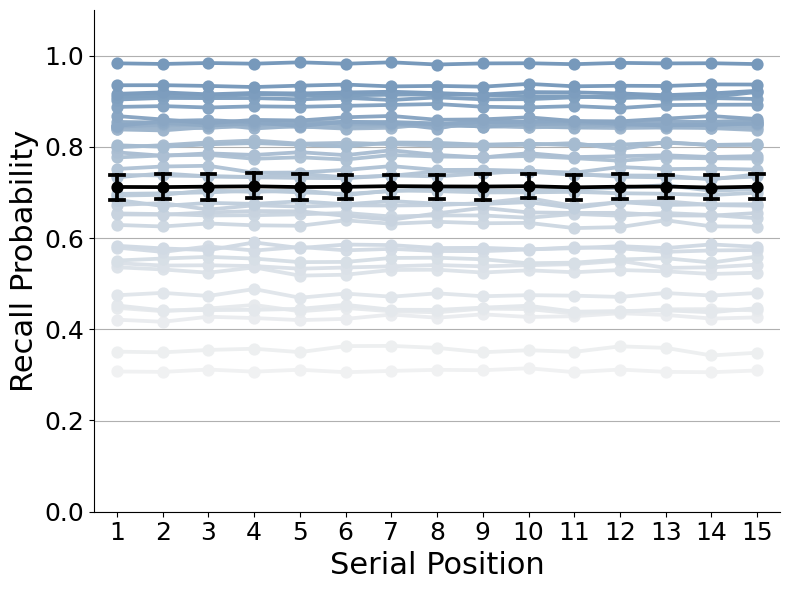

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = avg_spc_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='recalled', ci=None, ax=ax, color=colors[i])
    
spc = sns.pointplot(data=avg_spc_df, x='serialpos', y='recalled', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.1)
spc.yaxis.grid()
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()

In [17]:
# Probability of first recall
recword = full_evs_sim_test.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']
first_recall_df

,subject,serialpos,recalled,n_lists,prob
0,LTP564,1,6538,10000,0.6538
1,LTP564,2,2159,10000,0.2159
2,LTP564,3,728,10000,0.0728
3,LTP564,4,236,10000,0.0236
4,LTP564,5,112,10000,0.0112
...,...,...,...,...,...
595,LTP605,11,38,9999,0.0038
596,LTP605,12,33,9999,0.0033
597,LTP605,13,32,9999,0.0032
598,LTP605,14,23,9999,0.0023


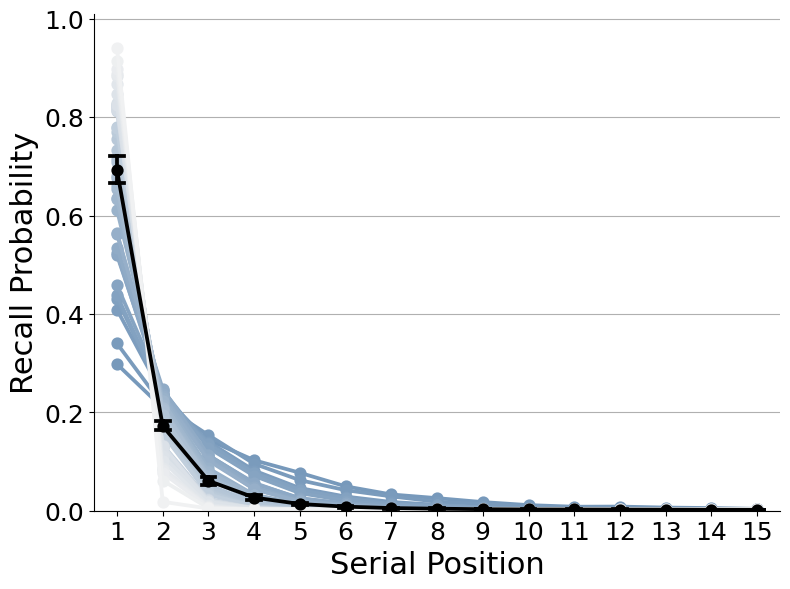

In [18]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = first_recall_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='prob', ci=None, ax=ax, color=colors[len(colors)-i-1])

spc = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.01)
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
spc.yaxis.grid()
plt.show()

In [19]:
# Lag CRP
rec_word_types_all = ['REC_WORD', 'REC_WORD_VV']
present_types = set(full_evs_sim_test['type'].unique())
present_rec_types = [t for t in rec_word_types_all if t in present_types]

need_types = ['WORD'] + present_rec_types
clean_evs = full_evs_sim_test[full_evs_sim_test['type'].isin(need_types)].copy()

for t in present_rec_types:
    if t != 'REC_WORD':
        clean_evs.loc[clean_evs['type'] == t, 'type'] = 'REC_WORD'

is_word = clean_evs['type'].eq('WORD')
is_rec  = clean_evs['type'].eq('REC_WORD')

temporal_evs = clean_evs[~is_word].copy()
temporal_evs

,experiment,item,itemno,item_val,trial,rectime,recalled,recallpos,serialpos,subject,type,val_list_avg,val_guess,pos_x,pos_y,session,value_condition
150000,VCsim,cereal,41,13,0,0,1,1,1,LTP564,REC_WORD,10.266667,11,0.228538,0.428303,0,Temporal
150001,VCsim,dumbells,550,12,0,0,1,11,2,LTP564,REC_WORD,10.266667,11,0.138759,0.770747,0,Temporal
150002,VCsim,ear_plugs,75,10,0,0,1,4,3,LTP564,REC_WORD,10.266667,11,0.345559,0.535730,0,Temporal
150003,VCsim,bird,21,7,0,0,1,6,4,LTP564,REC_WORD,10.266667,11,0.651673,0.824300,0,Temporal
150004,VCsim,oatmeal,620,12,0,0,1,9,5,LTP564,REC_WORD,10.266667,11,0.424855,0.659813,0,Temporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274958,VCsim,checkers,44,24,9999,9999,1,1,7,LTP605,REC_WORD,20.933333,13,0.876870,0.712089,999,Random
10274959,VCsim,checkers,44,24,9999,9999,1,1,7,LTP605,REC_WORD,20.933333,13,0.876870,0.712089,999,Random
10274960,VCsim,guitar_strings,574,20,9999,9999,1,2,9,LTP605,REC_WORD,20.933333,13,0.097393,0.305856,999,Random
10274961,VCsim,amplifier,5,24,9999,9999,1,5,13,LTP605,REC_WORD,20.933333,13,0.108201,0.556610,999,Random


In [20]:
crp_df = full_evs_sim_test.groupby(['subject']).apply(
    pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=14).reset_index()

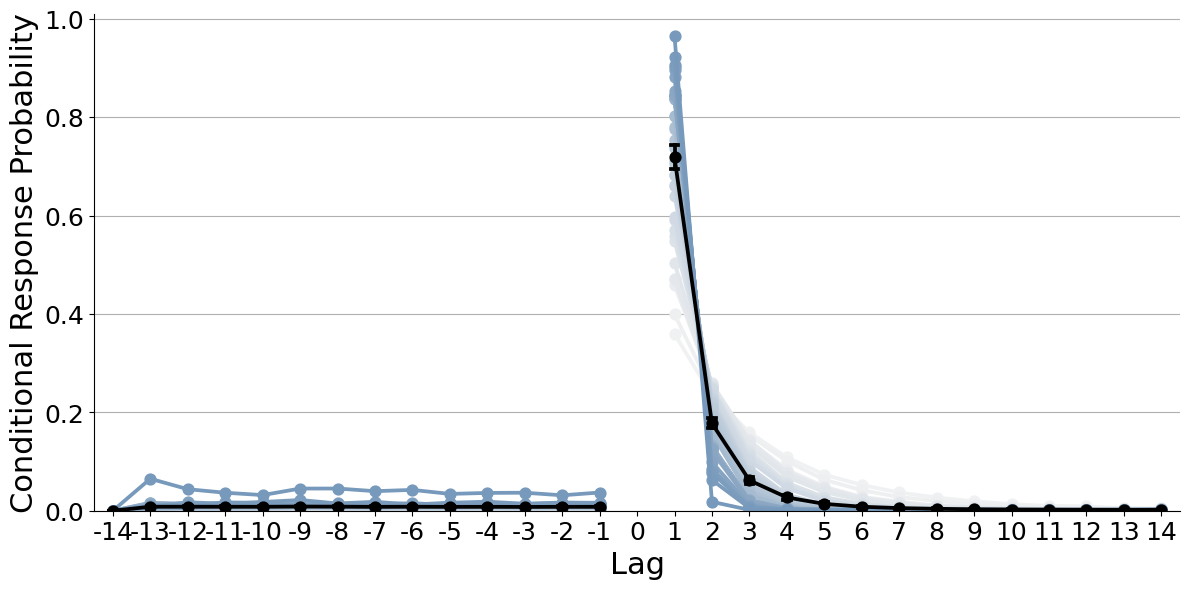

In [21]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax = plt.gca()

from matplotlib.colors import ListedColormap

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_crp = crp_df.query('subject == @sub')
    sns.pointplot(data=sub_crp, x="lag", y="prob", 
                  color= colors[i], 
                  ax=ax,
                  linestyles="-")

crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=68,
                    color='k', capsize=.2, ax=ax)

ax.set_xlabel('Lag', fontsize=22)
ax.set_ylabel('Conditional Response Probability', fontsize=22)
ax.tick_params(labelsize=18)
plt.ylim([0,1.01])
ax.yaxis.grid()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
temporal_clustering_df = full_evs_sim_test.groupby(['subject']).apply(
    pd_temp_fact,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    skip_first_n=0).rename('TC').reset_index()
temporal_clustering_df.sort_values(by='TC', ascending=True)

,subject,TC
30,LTP596,0.751660
5,LTP569,0.779329
4,LTP568,0.815410
31,LTP597,0.821600
33,LTP599,0.822699
39,LTP605,0.835802
3,LTP567,0.857677
14,LTP579,0.860321
10,LTP575,0.865734
38,LTP604,0.873594


In [23]:
word_evs = full_evs_sim_test[full_evs_sim_test['type'] == 'WORD']
error_by_trial = (word_evs.groupby(['subject', 'session', 'trial'], as_index=False)
                  .agg(val_list_avg=('val_list_avg', 'first'),
                       val_guess=('val_guess', 'first'),
                       item_count=('item', 'size'),
                       value_condition=('value_condition', 'first')))
error_by_trial['abs_error'] = (error_by_trial['val_guess'] - error_by_trial['val_list_avg']).abs()
error_by_trial

,subject,session,trial,val_list_avg,val_guess,item_count,value_condition,abs_error
0,LTP564,0,0,10.266667,11,15,Temporal,0.733333
1,LTP564,0,1,10.466667,9,15,Random,1.466667
2,LTP564,0,2,28.533333,15,15,Temporal,13.533333
3,LTP564,0,3,21.733333,15,15,Temporal,6.733333
4,LTP564,0,4,19.400000,15,15,Random,4.400000
...,...,...,...,...,...,...,...,...
399995,LTP605,999,9995,30.266667,15,15,Random,15.266667
399996,LTP605,999,9996,24.933333,15,15,Random,9.933333
399997,LTP605,999,9997,20.800000,15,15,Random,5.800000
399998,LTP605,999,9998,20.866667,15,15,Random,5.866667


In [26]:
error_by_sub_cond = (error_by_trial.groupby(['subject', 'value_condition'], as_index=False)
                     .agg(error_diff=('abs_error', 'mean')))

error_wide = (error_by_sub_cond.pivot(index='subject', columns='value_condition', values='error_diff').reset_index())
error_wide = error_wide.dropna(subset=['Temporal', 'Random'])
error_wide['error_diff'] = error_wide['Temporal'] - error_wide['Random']
error_wide

value_condition,subject,Random,Temporal,error_diff
0,LTP564,10.432533,10.618120,0.185587
1,LTP565,10.573267,10.502720,-0.070547
2,LTP566,10.583387,10.446120,-0.137267
3,LTP567,10.362240,10.637387,0.275147
4,LTP568,10.462640,10.369267,-0.093373
5,LTP569,10.424773,10.682933,0.258160
6,LTP571,10.365000,10.719653,0.354653
7,LTP572,10.728800,10.481200,-0.247600
8,LTP573,10.379293,10.401200,0.021907
9,LTP574,10.310920,10.271293,-0.039627


In [27]:
error_by_sub = error_wide[['subject', 'error_diff']]
merged_df = pd.merge(temporal_clustering_df, error_by_sub, on='subject')

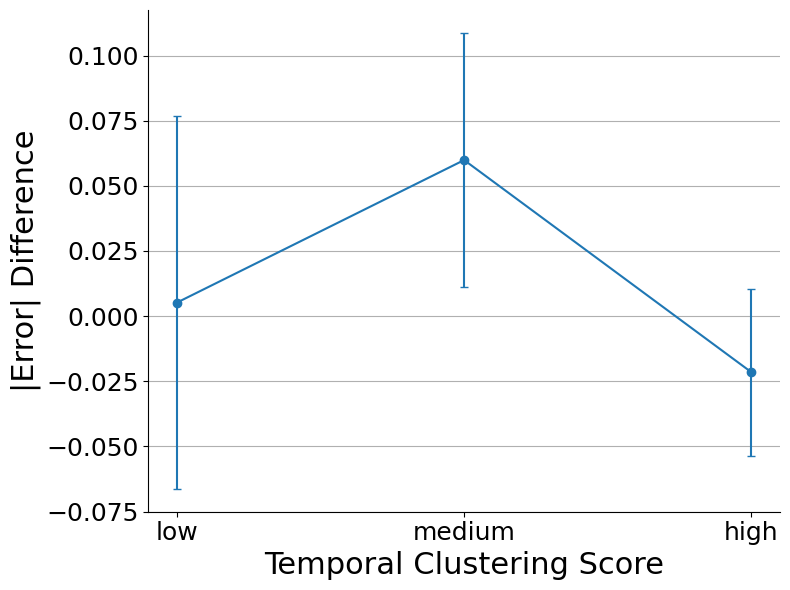

In [30]:
edges = np.linspace(merged_df['TC'].min(), merged_df['TC'].max(), 4)  # 3 bins -> 4 edges
merged_df['TC_bin'] = pd.cut(merged_df['TC'], 
                             bins=edges, 
                             labels=['low', 'medium', 'high'],
                             include_lowest=True,
                             right=True)

cats = pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)
merged_df['TC_bin'] = merged_df['TC_bin'].astype(cats)

summ = (merged_df.groupby('TC_bin', observed=True)['error_diff'].agg(['mean','count','std']).reset_index())
summ['se'] = summ['std'] / np.sqrt(summ['count'])
summ['x'] = summ['x'] = summ['TC_bin'].cat.codes

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(summ['x'], summ['mean'], yerr=summ['se'], fmt='o-', capsize=3)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['low','medium','high'])
ax.set_xlabel('Temporal Clustering Score', fontsize=22)
ax.set_ylabel('|Error| Difference', fontsize=22)
ax.tick_params(labelsize=18)
ax.yaxis.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

#### sim_data_null

In [47]:
full_evs_sim_null = pd.concat([pd.read_pickle(p) for p in glob.glob("sim_data_null/*.pkl")], ignore_index=True)
full_evs_sim_null

,experiment,item,itemno,item_val,trial,rectime,recalled,recallpos,serialpos,subject,type,val_list_avg,val_guess,pos_x,pos_y,session,value_condition
0,VCsim,lilies,361,11,0,0,1,6,1,LTP564,WORD,9.866667,10,0.454428,0.827987,999,Temporal
1,VCsim,orchids,624,9,0,0,1,10,2,LTP564,WORD,9.866667,10,0.256531,0.641284,999,Temporal
2,VCsim,napkins,140,9,0,0,1,8,3,LTP564,WORD,9.866667,10,0.640380,0.292402,999,Temporal
3,VCsim,bread,267,7,0,0,1,2,4,LTP564,WORD,9.866667,10,0.893125,0.268382,999,Temporal
4,VCsim,cat,39,6,0,-1,0,-1,5,LTP564,WORD,9.866667,10,0.179138,0.753685,999,Temporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272824,VCsim,eye_drops,556,34,9999,9999,1,7,9,LTP605,REC_WORD,30.533333,15,0.458501,0.417467,1998,Random
10272825,VCsim,records,648,32,9999,9999,1,3,11,LTP605,REC_WORD,30.533333,15,0.259002,0.780935,1998,Random
10272826,VCsim,tires,455,34,9999,9999,1,4,12,LTP605,REC_WORD,30.533333,15,0.353634,0.003318,1998,Random
10272827,VCsim,muffins,136,24,9999,9999,1,1,13,LTP605,REC_WORD,30.533333,15,0.533262,0.237119,1998,Random


In [48]:
# Recall probability per subject
pres = full_evs_sim_null.type=='WORD'
recall_by_sub = full_evs_sim_null[pres].groupby('subject')\
    .agg({'recalled':'mean'})\
    .rename(columns={"recalled":"Recall Probability"}
)
recall_by_sub = recall_by_sub.reset_index()
recall_by_sub = recall_by_sub.sort_values(by="Recall Probability", ascending=True)
sub_recall = recall_by_sub.subject.values
recall_by_sub

,subject,Recall Probability
30,LTP596,0.310827
5,LTP569,0.353587
4,LTP568,0.427780
31,LTP597,0.440900
33,LTP599,0.442240
39,LTP605,0.475787
3,LTP567,0.525853
14,LTP579,0.534900
10,LTP575,0.550487
38,LTP604,0.572480


In [49]:
# Overall recall probability
print(f"Mean = {recall_by_sub['Recall Probability'].mean()}, SD = {recall_by_sub['Recall Probability'].std()}")

Mean = 0.7121381666666666, SD = 0.17474782890849777


In [50]:
# Serial position curve
spc_df = full_evs_sim_null.query("type=='WORD'").groupby(
    ['subject', 'session', 'serialpos']
).agg({'recalled':np.nanmean}).reset_index()

avg_spc_df = spc_df.groupby(["subject","serialpos"]).agg({"recalled":"mean"}).reset_index()
avg_spc_df

,subject,serialpos,recalled
0,LTP564,1,0.671185
1,LTP564,2,0.669621
2,LTP564,3,0.671183
3,LTP564,4,0.673581
4,LTP564,5,0.670123
...,...,...,...
595,LTP605,11,0.479103
596,LTP605,12,0.474130
597,LTP605,13,0.472719
598,LTP605,14,0.477517


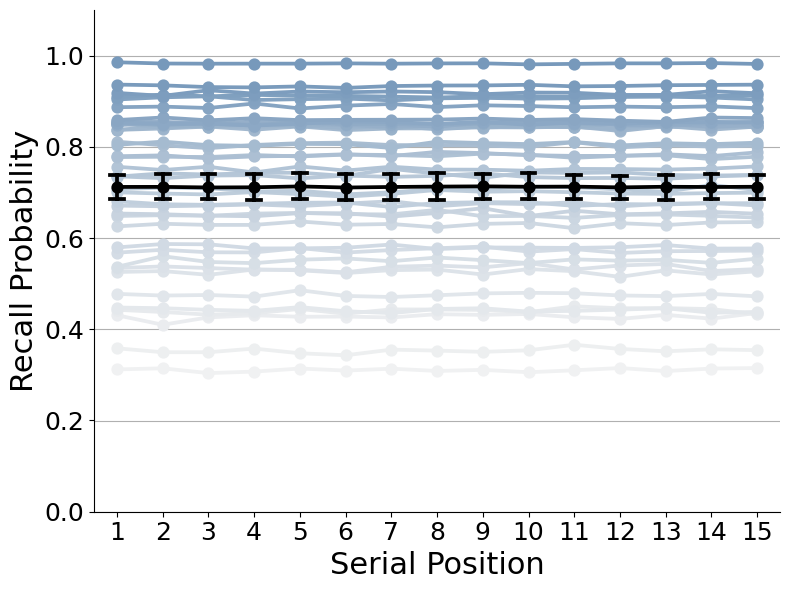

In [51]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = avg_spc_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='recalled', ci=None, ax=ax, color=colors[i])
    
spc = sns.pointplot(data=avg_spc_df, x='serialpos', y='recalled', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.1)
spc.yaxis.grid()
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
plt.show()

In [52]:
# Probability of first recall
recword = full_evs_sim_null.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']
first_recall_df

,subject,serialpos,recalled,n_lists,prob
0,LTP564,1,6549,10000,0.6549
1,LTP564,2,2191,10000,0.2191
2,LTP564,3,692,10000,0.0692
3,LTP564,4,255,10000,0.0255
4,LTP564,5,93,10000,0.0093
...,...,...,...,...,...
595,LTP605,11,31,9999,0.0031
596,LTP605,12,35,9999,0.0035
597,LTP605,13,31,9999,0.0031
598,LTP605,14,21,9999,0.0021


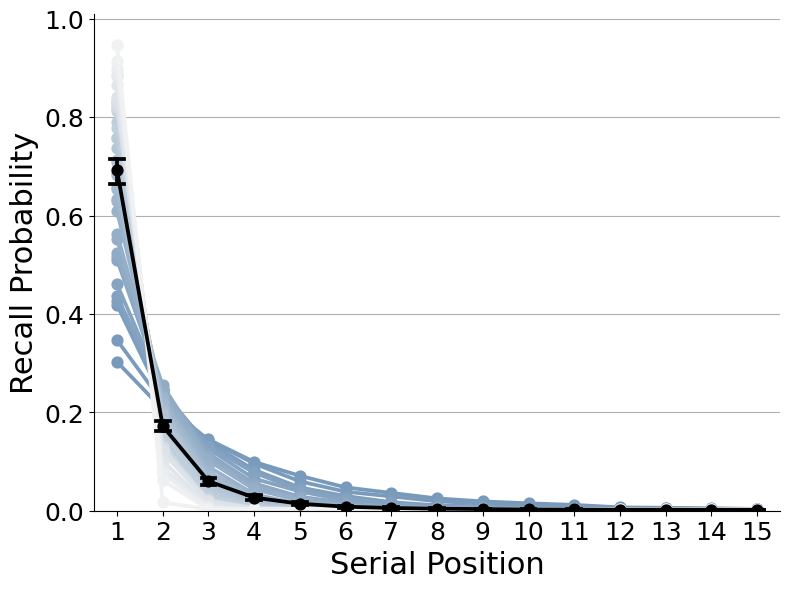

In [53]:
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_df = first_recall_df.query('subject == @sub')
    sub_spc = sns.pointplot(data=sub_df, x='serialpos', y='prob', ci=None, ax=ax, color=colors[len(colors)-i-1])

spc = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=68, capsize=.3, ax=ax, color="k")

plt.xlabel('Serial Position', fontsize=22)
plt.ylabel('Recall Probability', fontsize=22)
plt.tick_params(labelsize=18)
plt.ylim(0, 1.01)
plt.tight_layout()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
spc.yaxis.grid()
plt.show()

In [54]:
# Lag CRP
rec_word_types_all = ['REC_WORD', 'REC_WORD_VV']
present_types = set(full_evs_sim_null['type'].unique())
present_rec_types = [t for t in rec_word_types_all if t in present_types]

need_types = ['WORD'] + present_rec_types
clean_evs = full_evs_sim_null[full_evs_sim_null['type'].isin(need_types)].copy()

for t in present_rec_types:
    if t != 'REC_WORD':
        clean_evs.loc[clean_evs['type'] == t, 'type'] = 'REC_WORD'

is_word = clean_evs['type'].eq('WORD')
is_rec  = clean_evs['type'].eq('REC_WORD')

temporal_evs = clean_evs[~is_word].copy()
temporal_evs

,experiment,item,itemno,item_val,trial,rectime,recalled,recallpos,serialpos,subject,type,val_list_avg,val_guess,pos_x,pos_y,session,value_condition
150000,VCsim,lilies,361,11,0,0,1,6,1,LTP564,REC_WORD,9.866667,10,0.454428,0.827987,999,Temporal
150001,VCsim,orchids,624,9,0,0,1,10,2,LTP564,REC_WORD,9.866667,10,0.256531,0.641284,999,Temporal
150002,VCsim,napkins,140,9,0,0,1,8,3,LTP564,REC_WORD,9.866667,10,0.640380,0.292402,999,Temporal
150003,VCsim,bread,267,7,0,0,1,2,4,LTP564,REC_WORD,9.866667,10,0.893125,0.268382,999,Temporal
150004,VCsim,glue,569,7,0,0,1,7,6,LTP564,REC_WORD,9.866667,10,0.164214,0.029462,999,Temporal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10272824,VCsim,eye_drops,556,34,9999,9999,1,7,9,LTP605,REC_WORD,30.533333,15,0.458501,0.417467,1998,Random
10272825,VCsim,records,648,32,9999,9999,1,3,11,LTP605,REC_WORD,30.533333,15,0.259002,0.780935,1998,Random
10272826,VCsim,tires,455,34,9999,9999,1,4,12,LTP605,REC_WORD,30.533333,15,0.353634,0.003318,1998,Random
10272827,VCsim,muffins,136,24,9999,9999,1,1,13,LTP605,REC_WORD,30.533333,15,0.533262,0.237119,1998,Random


In [55]:
crp_df = full_evs_sim_null.groupby(['subject']).apply(
    pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=14).reset_index()

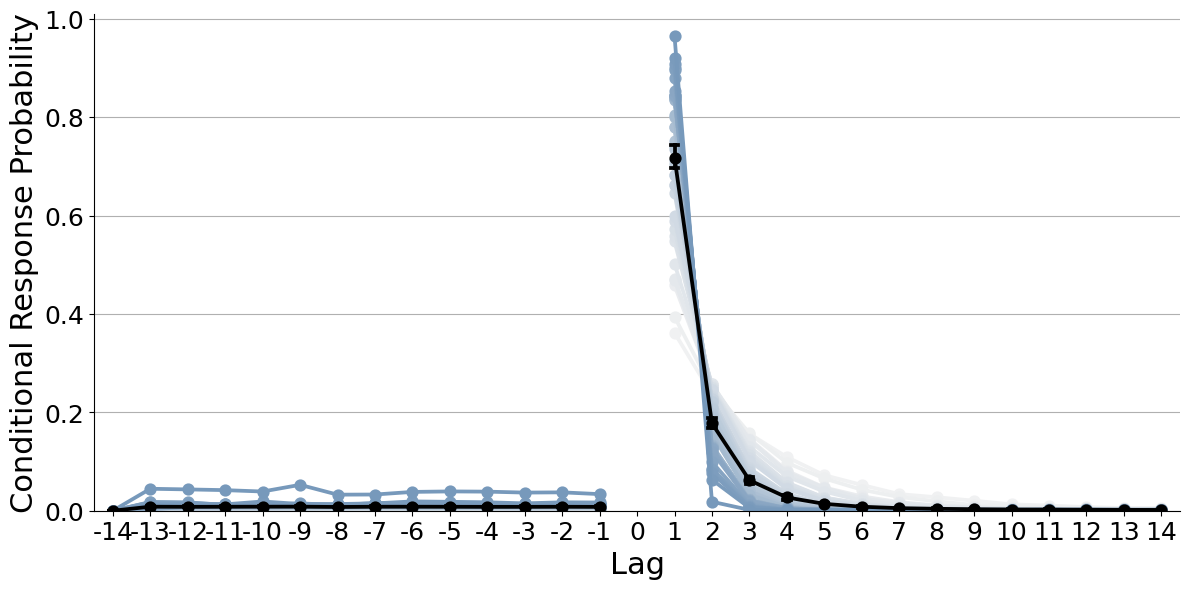

In [56]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('white')
ax = plt.gca()

from matplotlib.colors import ListedColormap

colors = sns.light_palette("#79B", len(sub_recall))
for i, sub in enumerate(sub_recall):
    sub_crp = crp_df.query('subject == @sub')
    sns.pointplot(data=sub_crp, x="lag", y="prob", 
                  color= colors[i], 
                  ax=ax,
                  linestyles="-")

crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=68,
                    color='k', capsize=.2, ax=ax)

ax.set_xlabel('Lag', fontsize=22)
ax.set_ylabel('Conditional Response Probability', fontsize=22)
ax.tick_params(labelsize=18)
plt.ylim([0,1.01])
ax.yaxis.grid()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.tight_layout()
plt.show()

In [57]:
temporal_clustering_df = full_evs_sim_null.groupby(['subject']).apply(
    pd_temp_fact,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    skip_first_n=0).rename('TC').reset_index()
temporal_clustering_df.sort_values(by='TC', ascending=True)

,subject,TC
30,LTP596,0.753351
5,LTP569,0.778607
4,LTP568,0.815302
31,LTP597,0.821869
33,LTP599,0.822079
39,LTP605,0.836514
3,LTP567,0.857098
14,LTP579,0.860657
10,LTP575,0.866069
38,LTP604,0.872508


In [58]:
word_evs = full_evs_sim_null[full_evs_sim_null['type'] == 'WORD']
error_by_trial = (word_evs.groupby(['subject', 'session', 'trial'], as_index=False)
                  .agg(val_list_avg=('val_list_avg', 'first'),
                       val_guess=('val_guess', 'first'),
                       item_count=('item', 'size'),
                       value_condition=('value_condition', 'first')))
error_by_trial['abs_error'] = (error_by_trial['val_guess'] - error_by_trial['val_list_avg']).abs()
error_by_trial

,subject,session,trial,val_list_avg,val_guess,item_count,value_condition,abs_error
0,LTP564,999,0,9.866667,10,15,Temporal,0.133333
1,LTP564,999,1,10.933333,10,15,Random,0.933333
2,LTP564,999,2,29.733333,15,15,Random,14.733333
3,LTP564,999,3,22.400000,15,15,Temporal,7.400000
4,LTP564,999,4,10.266667,12,15,Random,1.733333
...,...,...,...,...,...,...,...,...
399995,LTP605,1998,9995,22.933333,15,15,Temporal,7.933333
399996,LTP605,1998,9996,19.266667,15,15,Random,4.266667
399997,LTP605,1998,9997,25.000000,15,15,Temporal,10.000000
399998,LTP605,1998,9998,16.733333,15,15,Temporal,1.733333


In [59]:
error_by_sub_cond = (error_by_trial.groupby(['subject', 'value_condition'], as_index=False)
                     .agg(error_diff=('abs_error', 'mean')))

error_wide = (error_by_sub_cond.pivot(index='subject', columns='value_condition', values='error_diff').reset_index())
error_wide = error_wide.dropna(subset=['Temporal', 'Random'])
error_wide['error_diff'] = error_wide['Temporal'] - error_wide['Random']
error_wide

value_condition,subject,Random,Temporal,error_diff
0,LTP564,10.498573,10.373960,-0.124613
1,LTP565,10.383040,10.453733,0.070693
2,LTP566,10.672880,10.333760,-0.339120
3,LTP567,10.213293,10.429013,0.215720
4,LTP568,10.427987,10.860293,0.432307
5,LTP569,10.247493,10.466693,0.219200
6,LTP571,10.323067,10.306800,-0.016267
7,LTP572,10.525653,10.430707,-0.094947
8,LTP573,10.426213,10.360107,-0.066107
9,LTP574,10.436387,10.316240,-0.120147


In [60]:
error_by_sub = error_wide[['subject', 'error_diff']]
merged_df = pd.merge(temporal_clustering_df, error_by_sub, on='subject')

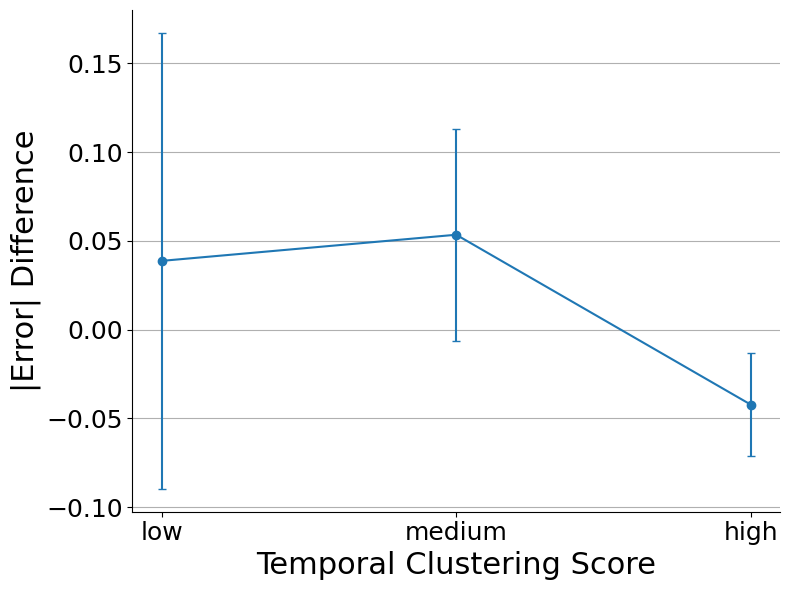

In [61]:
edges = np.linspace(merged_df['TC'].min(), merged_df['TC'].max(), 4)  # 3 bins -> 4 edges
merged_df['TC_bin'] = pd.cut(merged_df['TC'], 
                             bins=edges, 
                             labels=['low', 'medium', 'high'],
                             include_lowest=True,
                             right=True)

cats = pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)
merged_df['TC_bin'] = merged_df['TC_bin'].astype(cats)

summ = (merged_df.groupby('TC_bin', observed=True)['error_diff'].agg(['mean','count','std']).reset_index())
summ['se'] = summ['std'] / np.sqrt(summ['count'])
summ['x'] = summ['x'] = summ['TC_bin'].cat.codes

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(summ['x'], summ['mean'], yerr=summ['se'], fmt='o-', capsize=3)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['low','medium','high'])
ax.set_xlabel('Temporal Clustering Score', fontsize=22)
ax.set_ylabel('|Error| Difference', fontsize=22)
ax.tick_params(labelsize=18)
ax.yaxis.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()